# Chapter 1.4 - PID Control

** Contributors: Daniel P. Koch, Randal W. Beard **

### Table of Contents
1. [Motivating Example](#Motivating-Example)
  1. [Naive PD Control](#Naive-PID-Control)
  1. [Manifold PD Control](#Manifold-PID-Control)
1. [Preview: State-Space Control (Optimal Control)](#Preview:-State-Space-Control-%28Optimal-Control%29)
1. [Convergence Analysis of P and PD control](#Convergence-Analysis)
  1. [Lyapunov Refresher](#Lyapunov-Refresher)
  1. [Convergence Analysis for First-Order Kinematics](#Convergence-Analysis-for-First-Order-Kinematics)
  1. [Convergence Analysis for Second-Order Kinematics](#Convergence-Analysis-for-Second-Order-Kinematics)

## Motivating Example

We'll use as an example the azimuth control of a directional high-gain tracking antenna. The system state consists of the antenna direction $\Phi \in SO(2)$, and the angular velocity $\omega \in \mathbb{R}$. The input to the system is the torque $\tau$. The system dynamics are given by
\begin{align}
\dot{\Phi} &= \Phi \omega^\wedge \nonumber\\
\dot{\omega} &= -\frac{b}{I} \omega + \frac{1}{I} \tau \;,
\label{eq:dynamics}
\end{align}
where $I>0$ is the inertia and $b>0$ is a damping term. Following the discussion on solving differential equations, we will discretize these dynamics for computer simulation as
\begin{align}
\omega[k] &= \omega[k-1] + \left(-\frac{b}{I} \omega[k-1] + \frac{1}{I}\tau[k] \right) T_s \\
\Phi[k] &= \Phi[k-1] \circ \exp\left(\left(\omega[k] T_s\right)^\wedge\right)
\end{align}

We will use the native representation for elements of $SO(2)$ as $2\times2$ rotation matrices for our representation of the antenna orientation. This is implemented in the following Python class:

In [1]:
import numpy as np


class SO2:
    def __init__(self, G=np.eye(2)):
        self.mat = G

    def dot(self, rhs):
        return SO2(np.dot(self.mat, rhs.mat))

    @staticmethod
    def identity():
        return SO2(np.eye(2))

    def inverse(self):
        return SO2(self.mat.T)

    @staticmethod
    def exp(g):
        omega = SO2.vee(g)
        return SO2(np.array([[np.cos(omega), -np.sin(omega)], [np.sin(omega), np.cos(omega)]]))

    def log(self):
        theta = self.to_angle()
        return np.array([[0, -theta], [theta, 0]])

    @staticmethod
    def hat(omega):
        return np.array([[0.0, -omega],[omega, 0.0]])

    @staticmethod
    def vee(g):
        return g[1,0]

    def to_angle(self):
        return np.arctan2(self.mat[1,0], self.mat[0,0])

    @staticmethod
    def from_angle(theta):
        return SO2.exp(SO2.hat(theta))

    def visualize(self):
        pos = self.mat.dot(np.array([1.0, 0]))
        return pos[0], pos[1]

    def __str__(self):
        return self.mat.__str__()
    
    def __repr__(self):
        return self.mat.__str__()

We will set up our simulator to be able to accept a variety of controllers, which we will explore in the next sections. The simulator is implemented by the following class:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

class Simulator:
    def __init__(self, controller, commands=[0.0], command_duration=5.0):
        self.controller = controller

        # time
        self.dt = 0.01
        self.t = np.arange(0.0, command_duration*len(commands), self.dt)

        # system parameters
        self.I = 1.0
        self.b = 0.1

        # system state
        self.Phi = SO2()
        self.omega = 0.0

        # commands
        self.theta_c = np.zeros(self.t.shape)
        for i in range(len(commands)):
            self.theta_c[i*self.t.size//len(commands):(i+1)*self.t.size//len(commands)] = commands[i]

        # history
        self.theta_hist = np.zeros(self.t.shape)
        self.omega_hist = np.zeros(self.t.shape)
        self.tau_hist = np.zeros(self.t.shape)

    def animate(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal', xlim=[-1.2, 1.2], ylim=[-1.2,1.2])
        ax.axis('off')
        ax.set_title(self.controller.name)

        th = np.linspace(0, 2*np.pi, 100)
        ax.plot(np.cos(th), np.sin(th), 'k-')

        self.command_line = ax.plot([], [], 'ro', label='command')[0]
        self.actual_line = ax.plot([], [], 'bo', label='actual')[0]
        ax.legend(loc='center', numpoints=1)

        return animation.FuncAnimation(fig, self.step, frames=len(self.t), interval=int(1000*self.dt), blit=False, repeat=False)

    def step(self, k):
        # if the controller uses a manifold representation, convert the command to an element of SO(2)
        if self.controller.manifold:
            tau = self.controller.run(SO2.from_angle(self.theta_c[k]), self.Phi, self.omega)
        else:
            tau = self.controller.run(self.theta_c[k], self.Phi.to_angle(), self.omega)

        # propagate dynamics
        self.omega += (-self.b/self.I*self.omega + 1.0/self.I*tau)*self.dt
        self.Phi = self.Phi.dot(SO2.exp(SO2.hat(self.omega*self.dt)))

        # store history
        self.theta_hist[k] = self.Phi.to_angle()
        self.omega_hist[k] = self.omega
        self.tau_hist[k] = tau

        x_c, y_c = SO2.exp(SO2.hat(self.theta_c[k])).visualize()
        x, y = self.Phi.visualize()

        self.command_line.set_data(x_c, y_c)
        self.actual_line.set_data(x, y)

    def plot(self):
        plt.ioff()
        fig = plt.figure()

        ax = fig.add_subplot(311)
        ax.plot(self.t, self.theta_c, 'r-', label='command')
        ax.plot(self.t, self.theta_hist, 'b-', label='actual')
        ax.set_title(self.controller.name)
        ax.set_ylabel('theta (rad)')
        ax.legend()

        ax = fig.add_subplot(312)
        ax.plot(self.t, self.omega_hist, 'b-')
        ax.set_ylabel('omega (rad/s)')

        ax = fig.add_subplot(313)
        ax.plot(self.t, self.tau_hist, 'm-')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('torque (N*m)')

        plt.show()


### Naive PID Control

We will begin by designing a simple PID controller following a more traditional approach without using a manifold representation for the orientation. Representing the orientation of the antenna by the angle $\theta \in \left(-\pi,\pi \right]$, we can write the equation of motion as
\begin{equation}
I \ddot{\theta} + b \dot{\theta} = \tau \;,
\end{equation}
from which we obtain the transfer function
\begin{equation}
\Theta(s) = \frac{1}{s\left( Is + b \right)} T(s) \;.
\end{equation}
For a simple PD controller the control law is given by
\begin{equation}
\tau = k_p \left(\theta^c - \theta\right) - k_d \omega \;,
\end{equation}
where $\theta^c$ is the commanded orientation. This yields the closed-loop transfer function
\begin{equation}
\Theta(s) = \frac{k_p}{I s^2 + (b + k_d)s + k_p} \Theta^c (s) \;,
\end{equation}
from which we can see that the system will be stable as long as $k_p>0$ and $b+k_d>0$, and that there will be zero steady-state error to a step input.

Choosing appropriate gains $k_p$ and $k_d$, we will simulate the response of this controller to step inputs as follows:

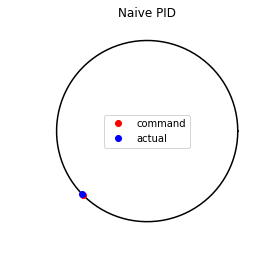

In [3]:
class PID_Naive:
    def __init__(self, kp, kd):
        self.name = "Naive PID"
        self.manifold = False

        self.kp = kp
        self.kd = kd

    def run(self, theta_c, theta, omega):
        return self.kp*(theta_c - theta) - self.kd*omega

sim = Simulator(PID_Naive(kp=2.0, kd=1.8), commands=[3*np.pi/4, -3*np.pi/4])
HTML(sim.animate().to_html5_video())

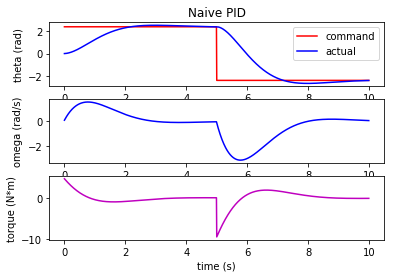

In [4]:
sim.plot()

The controller appears to perform well under these conditions. However, note that when the commanded angle changes from $3\pi/4$ to $-3\pi/4$, the controller spins all the way around the circle clockwise the long way, instead of taking the shortest path counter-clockwise. This happens because we are representing the orientation as angles in the range $(-\pi,\pi]$, and this representation contains no information about the relationship between angles near the boundaries of this range.

In the example above this behavior might be annoying, but if not accounted for it can actually destabilize the system because if it overshoots and crosses the $-\pi$ or $\pi$ boundaries it doesn't know to back up and instead tries to go all the way around the circle again:

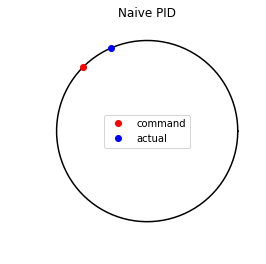

In [5]:
sim = Simulator(PID_Naive(kp=2.0, kd=0.4), commands=[3*np.pi/4], command_duration=10.0)
HTML(sim.animate().to_html5_video())

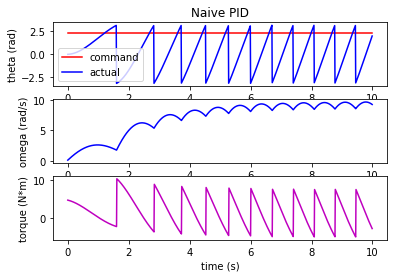

In [6]:
sim.plot()

Finally, if we were not careful about how we define our commanded angles, we can also get into trouble. For example, if we command we an angle greater than $2\pi$, the controller will want to go all the way around the circle once before settling on the desired orientation, but since the angle only goes up to $\pi$ it will never arrive there and will go unstable:

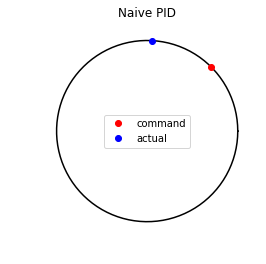

In [7]:
sim = Simulator(PID_Naive(kp=2.0, kd=1.8), commands=[2*np.pi + np.pi/4])
HTML(sim.animate().to_html5_video())

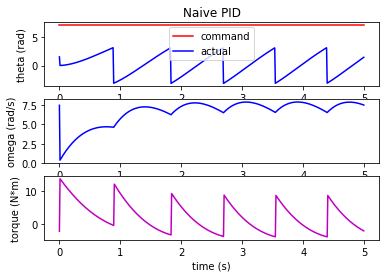

In [8]:
sim.plot()

For the case of $SO(2)$, all of these problems can be solved by adding in additional logic to carefully account for the angle-wrapping issues introduced by representing orientation as a scalar in the range $(-\pi,\pi]$. However, when we get to orientations in $SO(3)$ for three dimensions, that option will no longer be viable since orientation representations (such as Euler angles, quaternions, etc.) become much less trivial.

Additionally, these issue arise fundamentally because we are representing orientation as a member of a vector space, when in fact it is not. As will be shown in the next section, these issues disappear when representing the angle as a member of a Lie group, because all of the information that goes into the angle-wrapping logic is already captured by the group structure.

## Manifold PID Control

For a PID controller on the manifold, we can no longer write the error using subtraction because the manifold is not a vector space. Instead, the error is a member of the Lie algebra $\mathfrak{so}(2)$, and is computed using the logarithmic mapping as
\begin{equation}
e = \log\left( \Phi^c \circ \Phi^{-1} \right)^\vee \;.
\end{equation}
We then write our control law as
\begin{equation} \label{eq:tau_1}
\tau = k_p e - k_d \omega \;.
\end{equation}

This is simulated as follows using the same gains and step inputs as for the naive PD controller:

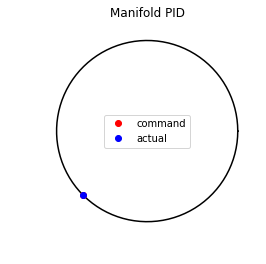

In [9]:
class PID_Manifold:
    def __init__(self, kp, kd):
        self.name = "Manifold PID"
        self.manifold = True

        self.kp = kp
        self.kd = kd

    def run(self, theta_c, theta, omega):
        u = self.kp*SO2.vee(theta_c.dot(theta.inverse()).log()) - self.kd*omega
        return u

sim = Simulator(PID_Manifold(kp=2.0, kd=1.8), commands=[3*np.pi/4, -3*np.pi/4])
HTML(sim.animate().to_html5_video())

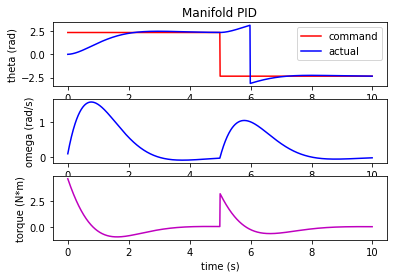

In [10]:
sim.plot()

As can be seen, the controller properly takes the shortest path around the circle, because it utilizes the information about relationships between angles encoded in the group structure. This looks slightly strange in the plots above as if it starts going the wrong direction, but that is a limitation of the visualization and is in fact the correct behavior.

Because the group structure properly accounts for the relationships between angles, we no longer have the stability issues caused by overshoot that we saw with the naive approach:

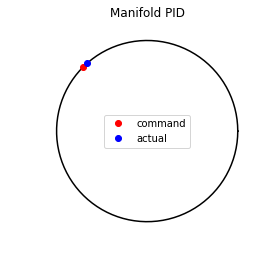

In [11]:
sim = Simulator(PID_Manifold(kp=2.0, kd=0.4), commands=[3*np.pi/4], command_duration=10.0)
HTML(sim.animate().to_html5_video())

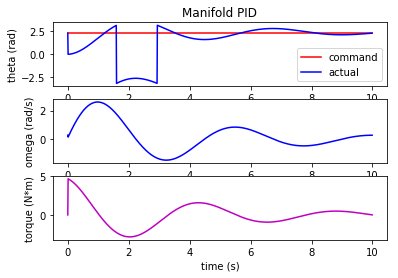

In [12]:
sim.plot()

In addition, by also encoding the commanded angles as members of $SO(2)$, we avoid issues with commanded angles that are outside of the range $(-\pi,\pi]$:

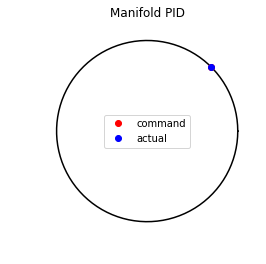

In [13]:
sim = Simulator(PID_Manifold(kp=2.0, kd=1.8), commands=[2*np.pi + np.pi/4])
HTML(sim.animate().to_html5_video())

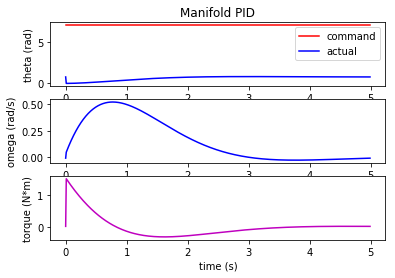

In [14]:
sim.plot()

Again this result looks strange in the plots, but this is because the plots do not encode the group structure that is accounted for in the controller and the result is correct.

## Preview: State-Space Control (Optimal Control)

The previous sections explored PID control on a manifold as a relatively straightforward application of control theory to manifolds. This section is a slightly more rigorous exploration of state-space control methods including optimal control.

### Vector space approach

We would usually like to write our system state as a vector, which in the case of the azimuth control problem would look like
\begin{equation}
\mathbf{x} = \begin{bmatrix} \theta \\ \omega \end{bmatrix} \in \mathbb{R}^2
\end{equation}
In order to track some reference trajectory $\mathbf{x}_\text{ref} \in \mathbb{R}^2$, we find the reference input $\mathbf{u}_\text{ref}$ such that $(\mathbf{x}_\text{ref}, \mathbf{u}_\text{ref})$ is an equilibrium point of the system. We then perform a change of variables as
\begin{align}
\tilde{\mathbf{x}} &= \mathbf{x} - \mathbf{x}_\text{ref} \;, \\
\tilde{\mathbf{u}} &= \mathbf{u} - \mathbf{u}_\text{ref} \;.
\end{align}
We can then compute the control as if for a regulation problem (driving the state to zero) as
\begin{equation}
\tilde{\mathbf{u}} = -\mathbf{K} \tilde{\mathbf{x}} \;,
\end{equation}
where finding the control gains matrix $\mathbf{K}$ is the subject of optimal control theory. The total control is given by
\begin{align}
\mathbf{u} &= -\mathbf{K} \tilde{\mathbf{x}} + \mathbf{u}_\text{ref} \\
\mathbf{u} &= -\mathbf{K} \left( \mathbf{x} - \mathbf{x}_\text{ref} \right) + \mathbf{u}_\text{ref} \;.
\end{align}

### Manifold approach

For a system state that has elements that are members of a Lie group, this approach won't work without modification because we're not in a vector space and so we don't have addition or subtraction. Instead, for the azimuth control case we would define our state as
\begin{equation}
\mathbf{x} = \left( \Phi, \omega \right) \in SO(2) \times \mathbb{R} \;,
\end{equation}
which is not a member of a vector space. Using the $\boxplus$/$\boxminus$ notation, we would define our error state $\tilde{\mathbf{x}} \in \mathbb{R}^2$ as 
\begin{align}
\tilde{\mathbf{x}} &= \mathbf{x} \boxminus \mathbf{x}_\text{ref} \;, \\
\tilde{\mathbf{u}} &= \mathbf{u} - \mathbf{u}_\text{ref} \;.
\end{align}
Here $\boxminus$ act appropriately for each element of $\mathbf{x}$, so that for the azimuth control case we would have
\begin{equation}
\mathbf{x} \boxminus \mathbf{x}_\text{ref} = \begin{bmatrix} \log\left( \Phi \circ \Phi_\text{ref}^{-1} \right)^\vee \\ \omega - \omega_\text{ref} \end{bmatrix}
\end{equation}
We would then, as above, have our control law as
\begin{align}
\tilde{\mathbf{u}} &= -\mathbf{K} \tilde{\mathbf{x}} \;, \\
\mathbf{u} &= -\mathbf{K} \tilde{\mathbf{x}} + \mathbf{u}_\text{ref} \;.
\end{align}

---

The open question now is how to choose $\mathbf{K}$ for a manifold system. Usually we'd have have
\begin{equation}
\dot{\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}
\end{equation}
and choose $\mathbf{K}$ based on $\mathbf{A}$ and $\mathbf{B}$ (and maybe $\mathbf{C}$ and $\mathbf{C}$), but we can't write that because it's not a vector! So we'd have to transform our dynamics into error space and do our work there, e.g.
\begin{equation}
\dot{\tilde{\mathbf{x}}} = \bar{\mathbf{A}} \tilde{\mathbf{x}} + \bar{\mathbf{B}} \tilde{\mathbf{u}}
\end{equation}
Or, it seems like in the literature this is where a bunch of the adjoint stuff shows up.

## Convergence Analysis

In this section we show Lyapnov functions and make convergence arguments for proportional and proportional-derivative control. 

### Lyapunov Refresher
To set the stage, suppose that we have a first order kinematic equation $\dot{z}=z+u$ where $z$ is the state and $u$ is the control variable.  Suppose that the objective is for $z$ to follow $z_d$.  Define the Lyapunov function
$$
V = \frac{1}{2}\|z_d-z\|^2
$$
and take the time derivative of $V$ to get
$$
\dot{V} = (z_d-z)(\dot{z}_d-\dot{z}) = (z_d-z)(\dot{z}_d-z-u).
$$
Selecting the control as 
$$
u=\dot{z}_d - z + k_p(z_d-z)
$$
gives
$$
\dot{V} = -k_p(z_d-z)^2
$$ 
establishing the convergence of $z(t)$ to $z_d(t)$.

Now consider the second order dynamics
\begin{align*}
\dot{z} &= w \\
\dot{w} &= u,
\end{align*}
and again suppose that the objective is for $z$ to follow $z_d$.  Define the Lyapunov function
$$
V = \frac{k_p}{2}\|z_d-z\|^2 + \frac{1}{2}\|w\|^2,
$$
and take the time derivative to get
\begin{align*}
\dot{V} &= k_p (z_d-z)^\top(\dot{z}_d-\dot{z}) + w^\top \dot{w} \\
        &= -k_p (z_d-z)^\top w + w^\top u +  k_p (z_d-z)^\top\dot{z}_d \\
        &= w^\top \left( u -k_p (z_d-z) \right) +  k_p (z_d-z)^\top\dot{z}_d.
\end{align*}
Selecting the control variable as
\begin{equation}\label{eq:control_u}
u = k_p(z_d-z) - k_d w
\end{equation}
gives 
$$
\dot{V} = -k_d\|w\|^2 +  k_p (z_d-z)^\top\dot{z}_d.
$$
If $\dot{z}_d=0$ then the system converges to the set $E=\{(z, w): w=0\}$.  The largest invariant set in $E$ is characterized by the property that $w\equiv\dot{w}\equiv 0$, which from Equation \eqref{eq:control_u} implies that $z\equiv z_d$.   Therefore, the LaSalle invariance lemma implies that $z(t)\to z_d$.  If $\dot{z}_d$ is not zero, then a straightforward argument shows that the system trajectories are uniformly ultimately bounded with ultimate bound related to $\dot{z}_d$.


### Convergence Analysis for First-Order Kinematics

Our objective is to derive a similar controller over a lie group for the first order kinematic expression
$$
\dot{R}=R\omega^\wedge,
$$
where the objective is to drive $R$ to $R_d$.  Define the error $\tilde{R}=R_d^\top R$, and consider the Lyapunov function
\begin{equation} \label{eq:Lyapunov-1}
V = \frac{1}{2}\|I-\tilde{R}\|^2,
\end{equation}
where the matrix norm is defined as 
$$
\|A\| \triangleq \sqrt{\langle\langle A, A \rangle\rangle}
$$
and the matrix inner product is defined as
$$
\langle\langle A, B \rangle\rangle = tr\left[ A^\top B \right],
$$
which is the Frobenius inner product of real matrices, and $tr\left[ \cdot \right]$ is the trace of the matrix.

We will have need of the following properties of the trace:

T.1. $tr\left[ A^\top \right]=tr\left[ A \right]$,

T.2. $tr\left[ AB \right] = tr\left[ BA \right]$,

T.3. $tr\left[ \alpha A + \beta B \right] = \alpha tr\left[ A \right] + \beta tr\left[ B \right]$ where $\alpha$ and $\beta$ are scalars, 

T.4. $tr\left[ AB \right] = 0$ when $A$ is a symmetric matrix and $B$ is a skew-symmetric matrix,

T.5. $tr\left[ a^\wedge b^\wedge \right] = -2a^\top b$, where $a, b \in \mathbb{R}^3$.

Using these properties we can rewrite equation \eqref{eq:Lyapunov-1} as
\begin{align*}
V &= \frac{1}{2}\|I-\tilde{R}\|^2 \\
  &= \frac{1}{2} tr\left[(I-\tilde{R})^\top(I-\tilde{R})\right] \\
  &= \frac{1}{2} tr\left[ I - \tilde{R} - \tilde{R}^\top + \tilde{R}^\top\tilde{R}\right] \\
  &= tr\left[I-\tilde{R}\right].
\end{align*}
Taking the derivative with respect to time gives
\begin{align}
\dot{V} &= -tr\left[ \dot{\tilde{R}} \right] \notag \\
        &= -tr\left[ \dot{R}_d^\top R + R_d^\top \dot{R} \right] \notag\\
        &= -tr\left[ \dot{R}_d^\top R + R_d^\top R \omega^\wedge \right] \notag\\
        &= -tr\left[ \dot{R}_d^\top R + \tilde{R} \omega^\wedge \right]. \label{eq:lyapunov_derivative_2}
\end{align}
Assume for the moment that $\dot{R}_d=0$, then 
\begin{equation}\label{eq:lyapunov_derivative_1}
\dot{V} = -tr\left[ \tilde{R}\omega^\wedge \right].
\end{equation}

Define the symetric and skew-symmetric operators as
\begin{align*}
\mathbb{P}_s (A) &\stackrel{\triangle}{=} \frac{1}{2}(A+A^\top) \\
\mathbb{P}_a (A) &\stackrel{\triangle}{=} \frac{1}{2}(A-A^\top),
\end{align*}
and note that $A=\mathbb{P}_s(A)+\mathbb{P}_a(A)$.  Equation \eqref{eq:lyapunov_derivative_1} then become
\begin{align*}
\dot{V} &= -tr\left[ \mathbb{P}_s(\tilde{R})\omega^\wedge + \mathbb{P}_a(\tilde{R})\omega^\wedge \right] \\
        &= -tr\left[ \mathbb{P}_a(\tilde{R})\omega^\wedge \right],
\end{align*}
where the second line follows form property T.4 above.  If the control variable $\omega$ is selected as
\begin{equation}\label{eq:omega_1}
\omega = k_p \mathbb{P}^\top_a(\tilde{R})^\vee,
\end{equation}
then 
\begin{align*}
\dot{V} &= - k_p tr\left[ \mathbb{P}_a(\tilde{R})\mathbb{P}^\top_a(\tilde{R}) \right] \\
        &= - k_p tr\left[ \mathbb{P}_a^\top(\tilde{R})\mathbb{P}_a(\tilde{R}) \right] \\
        &= - k_p \langle\langle \mathbb{P}_a(\tilde{R}), \mathbb{P}_a(\tilde{R}) \rangle\rangle \\
        &= - k_p \| \mathbb{P}_a(\tilde{R}) \|^2,
\end{align*}
which is negative definite in $\tilde{R}$.  Note that since $\mathbb{P}_a^\top(\tilde{R})=-\mathbb{P}_a(\tilde{R})$, Equation \eqref{eq:omega_1} can be written as 
\begin{equation}\label{eq:omega_2}
\omega = -k_p \mathbb{P}_a(\tilde{R})^\vee.
\end{equation}
Also note that if $R=e^{\theta u^\wedge}$, then $\log{R} = \theta u^{\wedge}$.  Also, since for $R\in SO(3)$ we have 
$$
R=e^{\theta u^\wedge} = \cos\theta I + \sin\theta u^{\wedge} + (1-\cos\theta)uu^\top
$$
that 
\begin{align*}
\mathbb{P}_a(\tilde{R}) &= \frac{1}{2}\left[\cos\theta I + \sin\theta u^{\wedge} + (1-\cos\theta)uu^\top
-\cos\theta I + \sin\theta u^{\wedge} - (1-\cos\theta)uu^\top \right] \\
  &= \sin\theta u^\wedge,
\end{align*}
that Equation \eqref{eq:omega_2} is closely related to Equation \eqref{eq:tau_1}.

Now suppose that $\dot{R}_d \neq 0$, and let $\omega = -k_p\mathbb{P}_a(\tilde{R})^\vee + \Omega$ where $\Omega$ will be a feedforward term that cancels the effect of $\dot{R}_d$.  From Equation \eqref{eq:lyapunov_derivative_2} we have
$$
\dot{V} = -k_p\|\mathbb{P}_a(\tilde{R})\|^2 - tr\left[ \dot{R}_d^\top R + \tilde{R}\Omega^\wedge \right].
$$
The goal is to select $\Omega$ so that the second term is equal to zero.  Toward that end we have
\begin{align*}
& tr\left[ \dot{R}_d^\top R + \tilde{R}\Omega^\wedge \right] = 0 \\
\iff & -tr\left[ \tilde{R}\Omega^\wedge \right] = tr\left[ \dot{R}_d^\top R \right] \\
\iff & -tr\left[ \mathbb{P}_s(\tilde{R})\Omega^\wedge + \mathbb{P}_a(\tilde{R})\Omega^\wedge \right] = tr\left[ \dot{R}_d^\top R \right] \\
\iff & -tr\left[ \mathbb{P}_a(\tilde{R})\Omega^\wedge \right] = tr\left[ \dot{R}_d^\top R \right] \quad \text{(by T.4)}\\
\iff & 2(\mathbb{P}_a(\tilde{R})^\vee)^\top \Omega = tr\left[ \dot{R}_d^\top R \right] \quad \text{(by T.5)}.
\end{align*}
Therefore let
$$
\Omega = \begin{cases}
         \frac{1}{2} tr\left[ \dot{R}_d^\top R \right] \frac{\mathbb{P}_a(\tilde{R})^\vee}{\|\mathbb{P}_a(\tilde{R})^\vee\|^2}, & \quad \text{if} \quad \|\mathbb{P}_a(\tilde{R})^\vee\| \neq 0 \\
         0, & \quad \text{otherwise}
         \end{cases}.
$$
We note that $ \|\mathbb{P}_a(\tilde{R})^\vee\|=0$ iff $\tilde{R}=I$.  The above Lyapunov analysis guarantees that $R\to R_d$.

### Convergence Analysis for Second-Order Kinematics

Now consider the second order dynamics
\begin{align*}
\dot{R} &= R\omega^\wedge \\
\dot{\omega} &= -\frac{b}{I}\omega + \frac{1}{I}\tau,
\end{align*}
and again let $\tilde{R}=R_d^\top R$.
  
Consider the Lyapunov function candidate
\begin{align*}
V &= \frac{k_p}{4I}\|I-\tilde{R}\|^2 + \frac{1}{2}\|\omega\|^2 \\
  &= \frac{k_p}{2I}tr\left[ I-\tilde{R} \right] + \frac{1}{2}\omega^\top \omega.
\end{align*}
Taking the time derivative of $V$ gives
\begin{align*}
\dot{V} &= -\frac{k_p}{2I} tr\left[ \dot{\tilde{R}} \right] + \omega^\top \dot{\omega} \\
        &= -\frac{k_p}{2I} tr\left[ \dot{R}_d^\top R + \tilde{R}\omega^\wedge \right] + \omega^\top (-\frac{b}{I}\omega + \frac{1}{I}\tau) \\
        &= -\frac{k_p}{2I} tr\left[ \dot{R}_d^\top R + (\mathbb{P}_s(\tilde{R})+\mathbb{P}_a(\tilde{R}))\omega^\wedge \right] + \omega^\top (-\frac{b}{I}\omega + \frac{1}{I}\tau) \\
        &= -\frac{k_p}{2I} tr\left[ \dot{R}_d^\top R + \mathbb{P}_a(\tilde{R})\omega^\wedge \right] + \omega^\top (-\frac{b}{I}\omega + \frac{1}{I}\tau) \\
        &= \frac{k_p}{I} \mathbb{P}_a^\top(\tilde{R})^\vee \omega + \omega^\top (-\frac{b}{I}\omega + \frac{1}{I}\tau) -\frac{k_p}{2I} tr\left[ \dot{R}_d^\top R \right]\\
        &= \omega^\top \left( \frac{k_p}{I} \mathbb{P}_a(\tilde{R})^\vee -\frac{b}{I}\omega + \frac{1}{I}\tau\right) -\frac{k_p}{2I} tr\left[ \dot{R}_d^\top R \right].
\end{align*}
Selecting the control input as
\begin{equation}\label{eq:tau_2}
\tau = -k_p \mathbb{P}_a(\tilde{R})^\vee - k_d\omega
\end{equation}
gives
$$
\dot{V} = -\left(\frac{b+k_d}{I}\right)\|\omega\|^2-\frac{k_p}{2I} tr\left[ \dot{R}_d^\top R \right].
$$
If $\dot{R}_d=0$ then $\dot{V}$ is negative semi-definite and system trajectories converge to the set $E=\{(R,\omega)|\omega=0\}$.  The largest invariant set in $E$ is characterized by $\omega(t)\equiv\dot{\omega}(t)\equiv 0$. From equation \eqref{eq:tau_2} that implies that in the largest invariant set in $E$, $\tilde{R}=I$.  Therefore, by the LaSalle invariance principle $R(t) \to R^d$.  Again, equation \eqref{eq:tau_2} is closely related to equation \eqref{eq:tau_1}.  Straightforward arguments can be used to argue that when $\dot{R}_d\neq 0$ that the trajectories of the system are uniformly ultimately bounded with ultimate bound depending on $\dot{R}_d$.